# IS319 - Deep Learning

## TP1 - Neural networks

The goal of this TP is to implement a simple feedforward neural network, but without the use of libraries like PyTorch or TensorFlow. We will only use NumPy.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

## 1. Activation function and its derivative

**(Question)** Implement the following activation function and its respective gradient (vector of partial derivatives). These should be applied element-wise to the input vector `a`.

In [4]:
def sigmoid(a):
    '''Return the element-wise sigmoid of the input vector.'''
    return 1/(1 + np.exp(-a))

def d_sigmoid(a):
    '''Return the partial derivatives of the sigmoid function
    with respect to the input vector.'''
    return sigmoid(a)*(1 - sigmoid(a))

In [5]:
a = np.random.randn(100)
assert np.all(sigmoid(a) >= 0.)
assert np.all(sigmoid(a) <= 1.)
assert sigmoid(0.) == 0.5
assert np.all(d_sigmoid(a) >= 0.)
assert np.all(d_sigmoid(a) <= 0.25)

## 2. Loss function and its derivative

**(Question)** Implement the following loss function and its respective gradient (vector of partial derivatives).

`y` and `d` correspond to predictions and ground-truth labels respectively. They are assumed to be be matrices of size `n_classes * n_samples`.

In [6]:
def squared_error(y, d):
    '''Return a scalar corresponding to the sum of squared errors.'''
    # The sum instead of mean will be more convenient for this TP
    return np.sum((y - d)**2)

def d_squared_error(y, d):
    '''Return the vector of partial derivatives of the sum of
    squared errors with respect to the predictions.'''
    return 2*(y - d)

In [7]:
y = np.random.randn(3, 100)
d = np.random.randn(3, 100)
assert squared_error(y, d) >= 0.
assert d_squared_error(y, d).shape == y.shape

## 3. Neural network architecture

We will implement a simple fully-connected neural network with **one hidden layer** and **one output layer**.

This neural network is defined by a number of inputs, a number of hidden units, and a number of output units.

The activation function will be sigmoid and the loss function will be the sum of squared errors, both implemented above.

**(Question)** Complete the class below to initialize the weights and biases randomly.

In [8]:
class NeuralNetwork():
    def __init__(self, n_input, n_hidden, n_output):
        '''Initialize a neural network with `n_input` input neurons,
        `n_hidden` hidden neurons and `n_output` output neurons.'''
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.init_weights()
        
    def init_weights(self):
        '''Initialize random weights with correct sizes in attributes `W1`, `b1`, `W2` and `b2`.'''
        self.W1 = np.random.randn(self.n_hidden, self.n_input)
        self.b1 = np.random.randn(self.n_hidden, 1)
        self.W2 = np.random.randn(self.n_output, self.n_hidden)
        self.b2 = np.random.randn(self.n_output, 1)

In [9]:
nn = NeuralNetwork(64, 32, 3)
assert nn.W1.ndim == 2
assert nn.b1.ndim == 2
assert nn.W2.ndim == 2
assert nn.b2.ndim == 2

## 4. Forward pass

The forward pass is defined as:
$$\begin{align*}
\mathbf{h}_1 &= \sigma(\mathbf{a}_1) \quad\text{with}\quad \mathbf{a}_1 = \mathbf{W}_1 \mathbf{x} + \mathbf{b}_1 \\
\mathbf{y} &= \sigma(\mathbf{a}_2) \quad\text{with}\quad \mathbf{a}_2 = \mathbf{W}_2 \mathbf{h}_1 + \mathbf{b}_2
\end{align*}$$

**(Question)** Implement the forward pass for input examples `X`. Save intermediate results `a1`, `h1` and `a2` into attributes (as they will be needed for the backpropagation algorithm).

In [10]:
class NeuralNetwork(NeuralNetwork): # (the method will be added to the `NeuralNetwork` class)
    def forward(self, X):
        self.a1 = np.dot(self.W1, X) + self.b1
        self.h1 = sigmoid(self.a1)
        self.a2 = np.dot(self.W2, self.h1) + self.b2
        return sigmoid(self.a2)

In [11]:
nn = NeuralNetwork(64, 32, 3)
X = np.random.randn(64, 100)
y = nn.forward(X)
assert y.shape == (3, 100)

**(Question)** Implement the function below to obtain a classification decision from the network. To do that, apply the forward pass, then choose the class corresponding to the maximum output value.

In [12]:
class NeuralNetwork(NeuralNetwork): # (the method will be added to the `NeuralNetwork` class)
    def predict(self, X):
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=0)

In [13]:
nn = NeuralNetwork(64, 32, 3)
X = np.random.randn(64, 100)
y = nn.predict(X)
assert y.shape == (100,)
assert np.any(y == 0) or np.any(y == 1) or np.any(y == 2)

## 5. Backward pass

**(Question)** Implement the backward pass for input examples `X`, ground-truth `d`, predictions `y`.

*Advice 1:* start by working on weights `d_W2` and `d_W1`, then work on the biases `d_b2` and `d_b1`.

*Advice 2:* keep track of the shapes of each partial derivatives using comments.

In [14]:
class NeuralNetwork(NeuralNetwork):
    def backward(self, X, y, d):
        '''Compute the partial derivatives of the loss function
        with respect to all weights of the neural network.
        Return these in variables `d_W1`, `d_b1`, `d_W2` and `d_b2`.'''
        # Backpropagation for the output layer
        # You should compute d_ey, d_ya2, d_a2w2 and finally delta2
        # Then, you can compute d_W2 and d_b2
        d_ey = d_squared_error(y, d)
        d_ya2 = d_sigmoid(self.a2)
        d_a2w2 = self.h1.T 
        delta2 = d_ey * d_ya2
        d_W2 = np.dot(delta2, d_a2w2)
        d_b2 = delta2.sum(axis=1, keepdims=True)

        # Backpropagation for the hidden layer
        # You should compute d_h1a1 and finally delta1
        # Then, you can compute d_W1 and d_b1
        d_h1a1 = d_sigmoid(self.a1)  
        delta1 = np.dot(self.W2.T, delta2) * d_h1a1
        d_W1 = np.dot(delta1, X.T)
        d_b1 = delta1.sum(axis=1, keepdims=True)

        return d_W1, d_b1, d_W2, d_b2

In [15]:
nn = NeuralNetwork(64, 32, 3)
X = np.random.randn(64, 100)
d = np.random.randint(0, 2, size=(3, 100))
y = nn.forward(X)
loss = squared_error(y, d)
d_W1, d_b1, d_W2, d_b2 = nn.backward(X, y, d)
assert d_W1.shape == nn.W1.shape
assert d_b1.shape == nn.b1.shape
assert d_W2.shape == nn.W2.shape
assert d_b2.shape == nn.b2.shape

## 6. Weights update with gradient descent

**(Question)** Complete the following code to implement one iteration of the training process:
- Apply the forward pass on training data and compute the loss
- Apply backpropagation to compute the gradient of the loss with respect to the network parameters
- Apply gradient descent to update the network parameters

In [16]:
class NeuralNetwork(NeuralNetwork):
    def train_iteration(self, X, d, lr=1e-2):
        # Apply the forward pass and compute the loss
        y = self.forward(X)
        loss = squared_error(y, d)
        # Apply backpropagation to compute the gradients
        d_W1, d_b1, d_W2, d_b2 = self.backward(X, y, d)

        # Apply gradient descent for convergence
        self.W1 -= lr*d_W1
        self.W2 -= lr*d_W2
        self.b1 -= lr*d_b1
        self.b2 -= lr*d_b2      
        return loss

In [17]:
nn = NeuralNetwork(64, 32, 3)
X = np.random.randn(64, 100)
d = np.random.randint(0, 2, size=(3, 100))
loss = nn.train_iteration(X, d, lr=100)
assert loss >= 0.

## 7. Mini-batch training loop

Now, we will implement the main training loop of our neural network.

We will use stochastic gradient descent with mini-batch: the weights will be updated by performing gradient descent on shuffled subsets of training data.

We will train the network for a number of epochs (an epoch is performed when the whole training set has been used with this mini-batch procedure).

**(Question)** Complete the code below to implement the training loop with minibatch stochastic gradient descent.

In [18]:
class NeuralNetwork(NeuralNetwork):
    def fit(self, X, d, batch_size, n_epochs=10, lr=1e-2, verbose=True):
        n_samples = X.shape[1]
        n_batches = (n_samples // batch_size) + 1
        for e in range(n_epochs):
            # Shuffle dataset
            permutation = np.random.permutation(n_samples)
            X, d = X[:, permutation], d[:, permutation]
            # Loop over each batch
            epoch_loss = 0.
            for b in range(0, n_samples, batch_size): # range(start, stop, step)
                # Grab the current batch in `X_batch` and `d_batch`
                X_batch = X[:, b:b+batch_size]
                d_batch = d[:, b:b+batch_size]
                # Apply training iteration and update epoch loss
                epoch_loss += self.train_iteration(X_batch, d_batch)
            # Compute average epoch loss and print it
            avg_epoch_loss = epoch_loss/n_batches
            if verbose :
                print(f"Average epoch loss {e+1}/{n_epochs} : {avg_epoch_loss}")

## 8. Train the network on the MNIST dataset

The MNIST dataset is composed of 70000 greyscale images of handwritten digits: 60000 images for training and 10000 for testing.

It is included in the `mnist.tgz` archive provided with this TP.

In [19]:
!tar xvzf ./mnist.tgz
images_train = np.load('./mnist-train-images.npy')
labels_train = np.load('./mnist-train-labels.npy')
images_test = np.load('./mnist-test-images.npy')
labels_test = np.load('./mnist-test-labels.npy')

mnist-test-images.npy
mnist-test-labels.npy
mnist-train-images.npy
mnist-train-labels.npy


**(Question)** Reshape the images into vectors and normalize the pixel values between 0 and 1. Convert the labels into one-hot vectors (*i.e.* vectors full of 0 and with only a 1 for the corresponding class). Store the results into `X_train`, `y_train`, `X_test` and `y_test` variables. Make sure to reshape to the following:
- Input data: `n_features x n_samples`
- Labels: `n_classes x n_samples`

In [20]:
# YOUR CODE HERE
def onehot(y, d=10) :
    y_onehot = []
    for v in y :
        acc = [0]*d
        acc[v] = 1
        y_onehot.append(acc)
    return np.array(y_onehot)
    
X_train = (images_train.reshape(images_train.shape[0], -1)/255).T
X_test = (images_test.reshape(images_test.shape[0], -1)/255).T
y_train, y_test = onehot(labels_train).T, onehot(labels_test).T

print(f"X_train shape : {X_train.shape},\nX_test shape : {X_test.shape},\ny_train shape : {y_train.shape},\ny_test shape :{y_test.shape}")

X_train shape : (784, 60000),
X_test shape : (784, 10000),
y_train shape : (10, 60000),
y_test shape :(10, 10000)


In [21]:
assert np.all(X_train >= 0.) and np.all(X_train <= 1.)
assert np.all(X_test >= 0.) and np.all(X_test <= 1.)
assert np.all(np.unique(y_train) == np.array([0., 1.])) 
assert np.all(np.unique(y_test) == np.array([0., 1.]))
assert np.all(np.sum(y_train, axis=0) == 1.)
assert np.all(np.sum(y_test, axis=0) == 1.)

**(Question)** Initialize a neural network for MNIST with 32 hidden units and train it for 10 epochs with a batch size of 512.

In [22]:
nn = NeuralNetwork(784, 32, 10)
nn.fit(X_train, y_train, batch_size=512, n_epochs=10)

Average epoch loss 1/10 : 365.28064213651425
Average epoch loss 2/10 : 211.53433936739125
Average epoch loss 3/10 : 157.34328577565324
Average epoch loss 4/10 : 116.96904709839579
Average epoch loss 5/10 : 103.00352632192936
Average epoch loss 6/10 : 94.45379526550285
Average epoch loss 7/10 : 88.27864892407284
Average epoch loss 8/10 : 83.30098360887199
Average epoch loss 9/10 : 79.55034317304761
Average epoch loss 10/10 : 76.29700389826667


**(Question)** Compute the classification accuracy on the train and test sets. To do that, you can use the predict function and compare them with the original labels (*i.e.* without one-hot encoding).

In [23]:
y_pred = nn.predict(X_test)
print(f"Accuracy score for MNIST : {sum(labels_test == y_pred)/len(y_pred)}")

Accuracy score for MNIST : 0.91


**(Question)** Compute and plot the confusion matrix for the test set. Which are the most difficult classes? Show some examples of misclassified images.

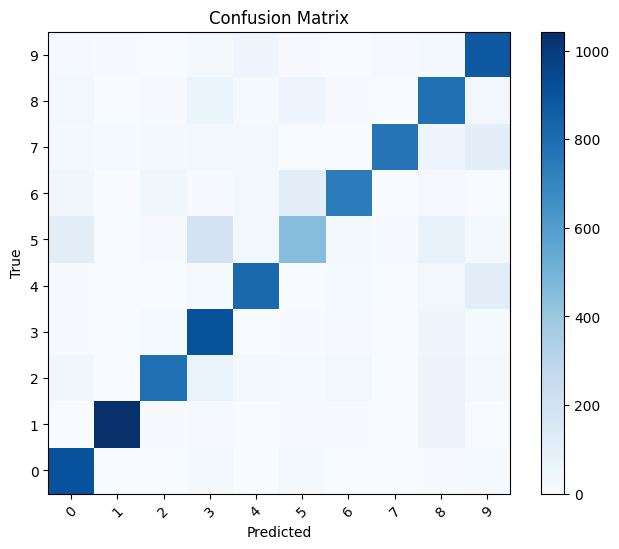

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels_test, y_pred)
labels= [i for i in range(10)]

# Create a figure and plot the confusion matrix
plt.figure(figsize=(8, 6))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add class labels to the plot
plt.gca().invert_yaxis()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**(Question)** Play around with hyperparameters of the model. What happens when the batch size if very small? And very large?

In [25]:
nn = NeuralNetwork(784, 32, 10)
batch_sizes = [2**x for x in range(5, 15)]
for batch_size in batch_sizes :
    print(f"fitting...", end='\r')
    nn.fit(X_train, y_train, batch_size=batch_size, n_epochs=10, verbose=False)
    y_pred = nn.predict(X_test)
    print(f"Accuracy score for MNIST with batch_size {batch_size}: {sum(labels_test == y_pred)/len(y_pred)}")

Accuracy score for MNIST with batch_size 32: 0.8309
Accuracy score for MNIST with batch_size 64: 0.9219
Accuracy score for MNIST with batch_size 128: 0.9281
Accuracy score for MNIST with batch_size 256: 0.9311
Accuracy score for MNIST with batch_size 512: 0.935
Accuracy score for MNIST with batch_size 1024: 0.9381
Accuracy score for MNIST with batch_size 2048: 0.939
Accuracy score for MNIST with batch_size 4096: 0.8561
Accuracy score for MNIST with batch_size 8192: 0.0975
Accuracy score for MNIST with batch_size 16384: 0.0974


## **Answer :**
**Hi**

## 9. Extension to more than one hidden layer

**(Question)** Extend your neural network model to handle more than one hidden layer.

In [41]:
# YOUR CODE HERE
class NeuralNetworkMutli(NeuralNetwork):
    def __init__(self, layer_sizes, activation_function=None, loss_function=None, d_activation_function=None):
        '''Initialize a neural network with the specified layer sizes.
        `layer_sizes` is a list that includes the number of neurons in each layer.'''
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.init_weights()
        self.activation_function = activation_function
        self.loss_function = loss_function
        if d_activation_function == None :
            self.d_activation_function = lambda x : activation_function(x)*(1 - activation_function(x))
        else :
            self.d_activation_function = d_activation_function
        self.d_loss_function = lambda y, d : y - d
    
    def init_weights(self):
        self.weights = [np.random.rand(y, x) for x, y in zip(self.layer_sizes[:-1], self.layer_sizes[1:])]
        self.bs = [np.random.rand(y, 1) for y in self.layer_sizes[1:]]

    def forward(self, X):
        self.activations = [X]
        self.zs = []
        for w, b in zip(self.weights, self.bs):
            z = np.dot(w, self.activations[-1]) + b
            self.zs.append(z)
            a = self.activation_function(z)
            self.activations.append(a)
        return self.zs[-1]

    def backward(self, y, d):
        self.d_weights = [np.zeros(w.shape) for w in self.weights]
        self.d_bs = [np.zeros(b.shape) for b in self.bs]
        
        delta = self.d_loss_function(y, d) * self.d_activation_function(self.activations[-1])

        self.d_weights[-1] = np.dot(delta, self.activations[-2].T)
        self.d_bs[-1] = delta.sum(axis=1, keepdims=True)
        
        
        for l in range(2, self.num_layers):
            delta = np.dot(self.weights[-l + 1].T, delta) * self.d_activation_function(self.activations[-l])
            self.d_weights[-l] = np.dot(delta, self.activations[-l - 1].T)
            self.d_bs[-l] = delta.sum(axis=1, keepdims=True)
        
    def train_iteration(self, X, d, lr=1e-2):
        y_pred = self.forward(X)
        self.backward(y_pred, d)
        
        self.weights = [w - lr * dw for w, dw in zip(self.weights, self.d_weights)]
        self.bs = [b - lr * db for b, db in zip(self.bs, self.d_bs)]
        
        loss = self.loss_function(y_pred, d)
        return loss


In [44]:
nnm = NeuralNetworkMutli([784, 32, 10], activation_function=sigmoid, loss_function=squared_error)
nnm.fit(X_train, y_train, batch_size=16, n_epochs=10)
y_pred = nnm.predict(X_test)
print(f"Accuracy score for MNIST : {sum(labels_test == y_pred)/len(y_pred)}")

Average epoch loss 1/10 : 26.775460007568476
Average epoch loss 2/10 : 11.148452788466535
Average epoch loss 3/10 : 8.365280377660952
Average epoch loss 4/10 : 7.4813887266791275
Average epoch loss 5/10 : 7.121206256399702
Average epoch loss 6/10 : 6.907872185872705
Average epoch loss 7/10 : 6.7545692911463995
Average epoch loss 8/10 : 6.6293201666451465
Average epoch loss 9/10 : 6.572569615580205
Average epoch loss 10/10 : 6.485556575901982
Accuracy score for MNIST : 0.8079


## 10. Extension to softmax and categorical cross-entropy

**(Question)** Extend your neural network model to use a softmax activation function for the output layer, and a categorical cross-entropy loss.
You can also experiment with the reLU activation for the hidden layer.

*Hint:* recall the partial derivatives formulation from logistic regression, and optimize the backpropagation for the output layer accordingly.

In [34]:
# YOUR CODE HERE
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return exp_x / exp_x.sum(axis=0, keepdims=True)

def reLU(x):
    return np.maximum(0, x)

def d_reLU(x):
    return np.where(x > 0, 1, 0)
    
def categorical_crossentropy(y, d):
    epsilon = 1e-15  # A small value to prevent log(0)
    y = np.clip(y, epsilon, 1 - epsilon)
    return -np.sum(d * np.log(y)) / y.shape[1]

In [35]:
nnm = NeuralNetworkMutli([784, 32, 10], activation_function=softmax, loss_function=categorical_crossentropy)
nnm.fit(X_train, y_train, batch_size=16, n_epochs=10)
y_pred = nnm.predict(X_test)
print(f"Accuracy score for MNIST : {sum(labels_test == y_pred)/len(y_pred)}")

Average epoch loss 1/10 : 3.4453041206475117
Average epoch loss 2/10 : 1.990644601740757
Average epoch loss 3/10 : 1.556813163626347
Average epoch loss 4/10 : 1.354213202502721
Average epoch loss 5/10 : 1.252771479152389
Average epoch loss 6/10 : 1.191710396315312
Average epoch loss 7/10 : 1.1358768963041534
Average epoch loss 8/10 : 1.1012636367892417
Average epoch loss 9/10 : 1.0869349556965489
Average epoch loss 10/10 : 1.066642602888333
Accuracy score for MNIST : 0.7019


In [36]:
nnm = NeuralNetworkMutli([784, 32, 10], activation_function=reLU, loss_function=categorical_crossentropy, d_activation_function=d_reLU)
nnm.fit(X_train, y_train, batch_size=2, n_epochs=10)
y_pred = nnm.predict(X_test)
print(f"Accuracy score for MNIST : {sum(labels_test == y_pred)/len(y_pred)}")

Average epoch loss 1/10 : 34.53647388656839
Average epoch loss 2/10 : 34.53762514073975
Average epoch loss 3/10 : 34.53762514073975
Average epoch loss 4/10 : 34.53762514073975
Average epoch loss 5/10 : 34.53762514073975
Average epoch loss 6/10 : 34.53762514073975
Average epoch loss 7/10 : 34.53762514073975
Average epoch loss 8/10 : 34.53762514073975
Average epoch loss 9/10 : 34.53762514073975
Average epoch loss 10/10 : 34.53762514073975
Accuracy score for MNIST : 0.0958


ReLU (Rectified Linear Unit):

ReLU is typically used as an activation function for hidden layers in deep neural networks.

It introduces non-linearity and sparsity in the network by outputting zero for negative inputs and passing positive inputs as.

ReLU is computationally efficient and has been widely used in deep learning due to its effectiveness in training deep network.

Softmax :

Softmax is used in the output layer of a neural network for multi-class classification tasks.

It transforms the network's raw output scores into a probability distribution over multiple classes.

Softmax is suitable for problems where you need to assign a probability to each class, and it ensures that the class probabilities sum to 1.

It's not typically used as an activation function in hiddelayers.